## 第一回卒論コンペ

### 解法

1.tokenizer : sudachi(A) dict-small

2.preprocess : tokenizer + neologdn + normalize number

3.model : lightGBM(Regression) + change parameters + ensemble

4.result : 50.4(single) → 51.0(ensemble)

https://zenn.dev/wsuzume/books/66b6fe7bb537b3e2b4bb/viewer/4b769d



In [3]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 15.2 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 210 kB 90.0 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 147 kB 84.0 MB/s 
     |████████████████████████████████| 112 kB 54.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9a254d364a46ec5bca2fff40a09b7553f491190fe72827a5375e9eb966da73a7
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [4]:
# ライブラリの導入
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score

def adapt_labels(labels):
  max_label = np.max(labels) # 2 or 4

  if max_label == 2:
    labels += 2
  elif max_label == 4:
    labels -= 2
  else:
    print('Exception error! please check with np.unique(labels).')
  return labels

In [5]:
#ファイル
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/grad_comp

Mounted at /content/drive
/content/drive/MyDrive/grad_comp


neo-small-B

In [6]:
# preprocess path
prepro = 'sudachi-neo-small/A'

# setup data

f = open('preprocess/' + prepro + '/text.prep_train.txt', 'r')
train_data = f.read()
train_data = train_data.split('\n')
del train_data[30000]

f = open('preprocess/' + prepro + '/text.prep_test.txt', 'r')
test_data = f.read()
test_data = test_data.split('\n')
del test_data[2500]

f = open('preprocess/' + prepro + '/text.prep_dev.txt', 'r')
dev_data = f.read()
dev_data = dev_data.split('\n')
del dev_data[2500]

# label
y_train = np.loadtxt('/content/drive/MyDrive/grad_comp/data/label.train.txt')
y_dev = np.loadtxt('/content/drive/MyDrive/grad_comp/data/label.dev.txt')

# adapt_labels(y_train)
# adapt_labels(y_dev)

u, counts = np.unique(y_train, return_counts=True)
print(u)
print(counts)

[-2. -1.  0.  1.  2.]
[3543 5593 9227 7760 3877]


In [7]:
import numbers

import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score

# coef = [0.5,1.8,2.3,2.8] # hyperparameter 45.5
# coef = [0.56067872,1.85788215,2.23106766,2.67266578]
def predict(X): # coef引数にしたほうがいい
    X_p = np.copy(X)
    for i, pred in enumerate(X_p):
        if pred < coef[0]:
            X_p[i] = -2
        elif pred >= coef[0] and pred < coef[1]:
            X_p[i] = -1
        elif pred >= coef[1] and pred < coef[2]:
            X_p[i] = 0
        elif pred >= coef[2] and pred < coef[3]:
            X_p[i] = 1
        else:
            X_p[i] = 2
    return X_p

def lgb_custom_metric_qwk_regression(preds, data):
    """LightGBM のカスタムメトリックを計算する関数

    回帰問題として解いた予測から QWK を計算する"""
    # 正解ラベル
    y_true = data.get_label()
    # 予測ラベル-ここを調整
    y_pred = predict(preds) # 4要素の閾値
    # QWK を計算する
    return 'qwk', qwk(y_true, y_pred), True


def qwk(y_true, y_pred):
    """QWK (Quadratic Weighted Kappa) を計算する関数"""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [9]:
import numpy as np

data = np.arange(1.95, 2.05, 0.03)
data = np.round(data, 2)

for i in data:
    print(i)

1.95
1.98
2.01
2.04


In [10]:
file_num = 0

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1013]	valid_0's qwk: 0.485862
1.6591037236646808 -1.737270716004355


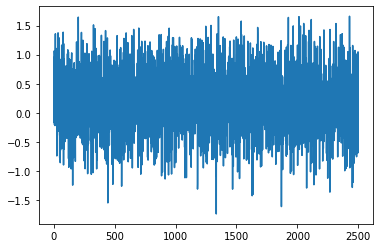

In [107]:
# 検証
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3100,norm='l1',analyzer='char',smooth_idf=True)
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
X_test = vectorizer.transform(test_data)
file_num += 1
X_train = X_train.toarray()
X_dev = X_dev.toarray()
test_list = []
# for i in data:
# best = [1.4,1.95,2.05,2.75] 48.1
# coef = [1.3,1.95,2.05,2.8] 48.3 B
# coef = [1.3,1.95,2.05,2.8]
# coef = [-0.5,-0.1,0.3,0.55]
coef = [-0.5,-0.1,0.25,0.58]
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_dev, y_dev, reference=lgb_train) 

# LightGBM parameters
# params = {
#       'objective': 'regression',
#       'metric': 'lgb_custom_metric_qwk_regression',
#       'verbose': -1,
#       'first_metric_only':True,
#       'learning_rate':0.05, # default:0.1
  # }

seed = 256

params = {
    'objective': 'regression',
    'metric': 'lgb_custom_metric_qwk_regression',
    'verbose': -1,
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.008,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 2,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    "lambda_l1": 1.1,
    'random_state': seed,     # default = None
}

model = lgb.train(params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=5000,
                early_stopping_rounds=500,
                verbose_eval=-1,
                feval=lgb_custom_metric_qwk_regression,
                )

y_preds = model.predict(X_test)
print(max(y_preds),min(y_preds))
x = np.arange(0, 2500, 1)
y = y_preds

# optimized = predict(y_pred)

import matplotlib.pyplot as plt
plt.plot(x,y)
plt.show()

In [ ]:
# アンサンブル

python ensemble.py best/507_7_50_0.889_depth_l2_add_A3150_eval.txt best/best_3_0.889_l2_add_A3150_eval.txt best/7_50_0.888_depth_l2_add_A3150_eval.txt best/8_33_0.889_depth_l2_add_A3150_eval.txt best/8_35_0.888_depth_l2_add_A3150_eval.txt best/8_38_0.889_depth_l2_add_A3150_eval.txt best/5_9_0.889_depth_l2_add_A3150_eval.txt

In [108]:
# No. 確認
file_num

33

In [109]:
# submit

y_preds = model.predict(X_test)
# coef = [-0.5,-0.1,0.3,0.68]
y_preds = predict(y_preds)
u, counts = np.unique(y_preds, return_counts=True)
print(u)
print(counts)
with open('src/A3100/' + str(file_num)+ str(seed) +'_add_A3100_eval.txt','w') as f:
  for y_pred in y_preds:
    y_pred = int(y_pred)
    y_pred = str(y_pred)
    f.write(y_pred + '\n')

[-2. -1.  0.  1.  2.]
[268 512 585 488 647]


In [ ]:
# 複数の結果を同時に submit
# n = 0
# for i in data:
#   optimized = test_list[n]
#   print(optimized)
#   n += 1
#   adapt_labels(optimized)
#   print(optimized)
#   with open('src/result/sec-' + str(i) + 'B3100_lgbp_norm_char_smooth_eval.txt','w') as f:
#     for y_pred in optimized:
#       y_pred = int(y_pred)
#       y_pred = str(y_pred)
#       f.write(y_pred + '\n')